In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
import seaborn as sns
import numpy as np
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, AdaBoostRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.preprocessing import StandardScaler
import xgboost as xgb

In [2]:
data = pd.read_csv("stock_price.csv")
data = data.iloc[::-1].reset_index(drop=True)

# Converting string - Volume and Change in numerals
def convert_string_to_numeral(data):
    if data[-1] == "B":
        return float(data[:-1])*1000
    return float(data[:-1])

data.Volume = data.Volume.apply(convert_string_to_numeral)
data['Change %'] = data['Change %'].apply(convert_string_to_numeral)

### Feature Creation/Extraction
In this section, I will focus on creating features from the Data, and by the end of it, select the top-K features will be used in the further analysis

To form features, I will perform basic transformations - such as taking the mean of last few days, lag, day of the month, month, etc.

To select the features, I will:

    1. Frame the dataset such that the "Close Price of the Next Day" becomes the target variable
    2. We will now use the values/features from the previous day as model inputs
    3. Try to predict the "Close Price" of the next day
    4. Compare various models as well
    5. Use something like a FFS/BFS or RFS to choose the top-K features

In [3]:
# Lag Features
data['Lag_1'] = data['Close'].shift(1)   # Previous day's close
data['Lag_5'] = data['Close'].shift(5)   # Close 5 days ago
data['Lag_30'] = data['Close'].shift(30) # Close 30 days ago

In [4]:
# Simple Moving Average
data['MA_5'] = data['Close'].rolling(window=5).mean()   # 5-day moving average
data['MA_30'] = data['Close'].rolling(window=30).mean() # 30-day moving average

In [5]:
# Exponential Moving Average
data['EMA_5'] = data['Close'].ewm(span=5, adjust=False).mean()   # 5-day EMA
data['EMA_30'] = data['Close'].ewm(span=30, adjust=False).mean() # 30-day EMA

In [6]:
# Standard Deviation
data['Volatility_5'] = data['Close'].rolling(window=5).std()   # 5-day volatility
data['Volatility_30'] = data['Close'].rolling(window=30).std() # 30-day volatility

In [7]:
# Percentage Change in Price
data['Price_Change_5'] = data['Close'].pct_change(periods=5)    # 5-day change
data['Price_Change_30'] = data['Close'].pct_change(periods=30)    # 5-day change

In [8]:
# Relative Strength Index
delta = data['Close'].diff(1)
gain = delta.where(delta > 0, 0)
loss = -delta.where(delta < 0, 0)
avg_gain = gain.rolling(window=14).mean()
avg_loss = loss.rolling(window=14).mean()
rs = avg_gain / avg_loss
data['RSI'] = 100 - (100 / (1 + rs))

In [9]:
data['Date'] = pd.to_datetime(data['Date'], errors='coerce')

# Month and Day
data['Day_of_Week'] = data['Date'].dt.dayofweek   # 0=Monday, 6=Sunday
data['Month'] = data['Date'].dt.month             # 1=January, 12=December

In [10]:
# Volume Weighted Average Price
data['VWAP'] = (data['Volume'] * data['Close']).cumsum() / data['Volume'].cumsum()

In [11]:
data['Price_Change'] = data['Close'].diff()  # Difference in close price
data['High_Low_Spread'] = data['High'] - data['Low']  # High minus Low
data['Open_Close_Spread'] = data['Open'] - data['Close']  # Open minus Close

# Momentum (difference between current close and 5-day/30-day moving averages)
data['Momentum_5'] = data['Close'] - data['Close'].rolling(window=5).mean()
data['Momentum_30'] = data['Close'] - data['Close'].rolling(window=30).mean()

# Ratio Features
data['High_Low_Ratio'] = data['High'] / data['Low']  # High/Low ratio
data['Close_Open_Ratio'] = data['Close'] / data['Open']  # Close/Open ratio

# Volatility Indicators
data['Price_Range_5'] = data['High'].rolling(window=5).max() - data['Low'].rolling(window=5).min()  # Price range in 5-day window
data['Price_Range_30'] = data['High'].rolling(window=30).max() - data['Low'].rolling(window=30).min()  # Price range in 30-day window

In [12]:
# Sharpe Ratio
data['Daily_Returns'] = data['Close'].pct_change()
risk_free_rate = 0.01 / 252 

window = 30  
data['Rolling_Mean_Returns'] = data['Daily_Returns'].rolling(window=window).mean()
data['Rolling_Std_Returns'] = data['Daily_Returns'].rolling(window=window).std()
data['Sharpe_Ratio'] = (data['Rolling_Mean_Returns'] - risk_free_rate) / data['Rolling_Std_Returns']

In [13]:
# Creating the Target Variable
data['Next_Day_Close'] = data['Close'].shift(-1)

In [14]:
data = data.dropna()
data.reset_index(inplace=True)
data = data.drop(['index'], axis=1)

In [15]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler

split_date = '2020-12-31'  

train = data[data['Date'] < split_date]
test = data[data['Date'] >= split_date]

X_train = train.drop(columns=['Next_Day_Close', 'Date'])
y_train = train['Next_Day_Close']

X_test = test.drop(columns=['Next_Day_Close', 'Date'])
y_test = test['Next_Day_Close']

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

minmax_scaler = MinMaxScaler()
X_train_normalized = minmax_scaler.fit_transform(X_train_scaled)
X_test_normalized = minmax_scaler.transform(X_test_scaled)

Linear Regression RMSE: 1.6736755306852225, MAE: 1.260710154530813


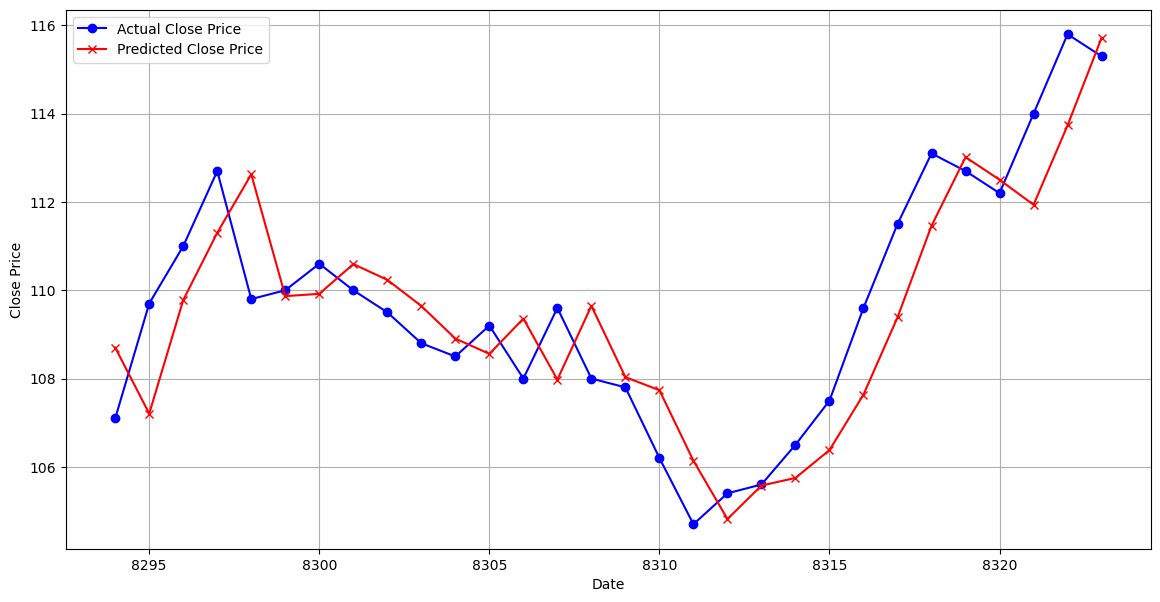

Random Forest RMSE: 2.059992618246289, MAE: 1.6018905359179048


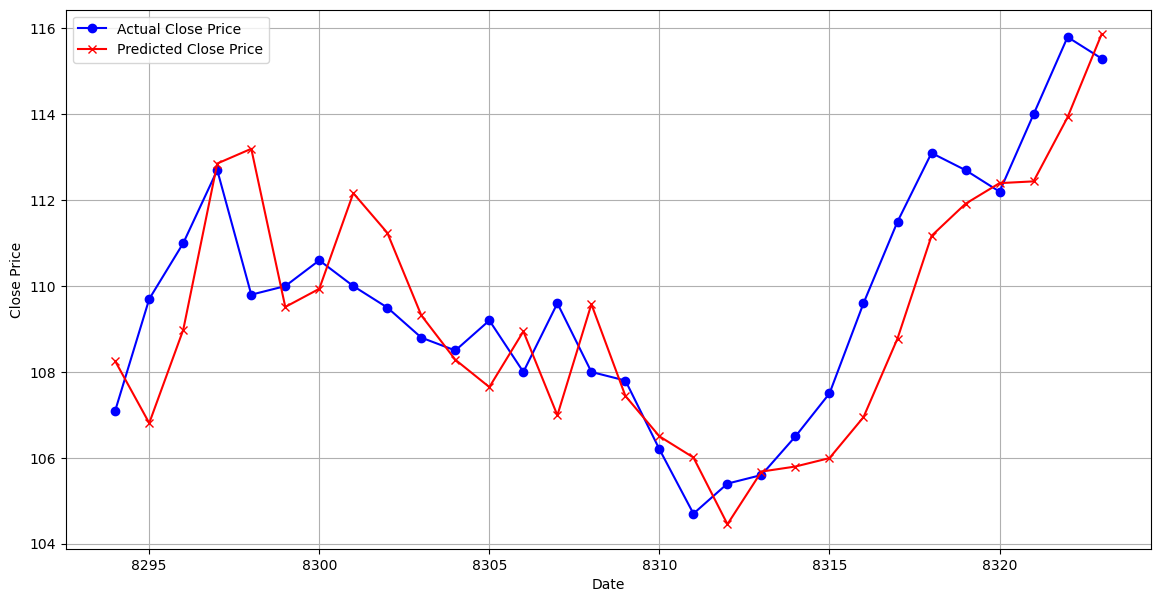

Ridge Regression RMSE: 1.6549498541702314, MAE: 1.2444109834163553


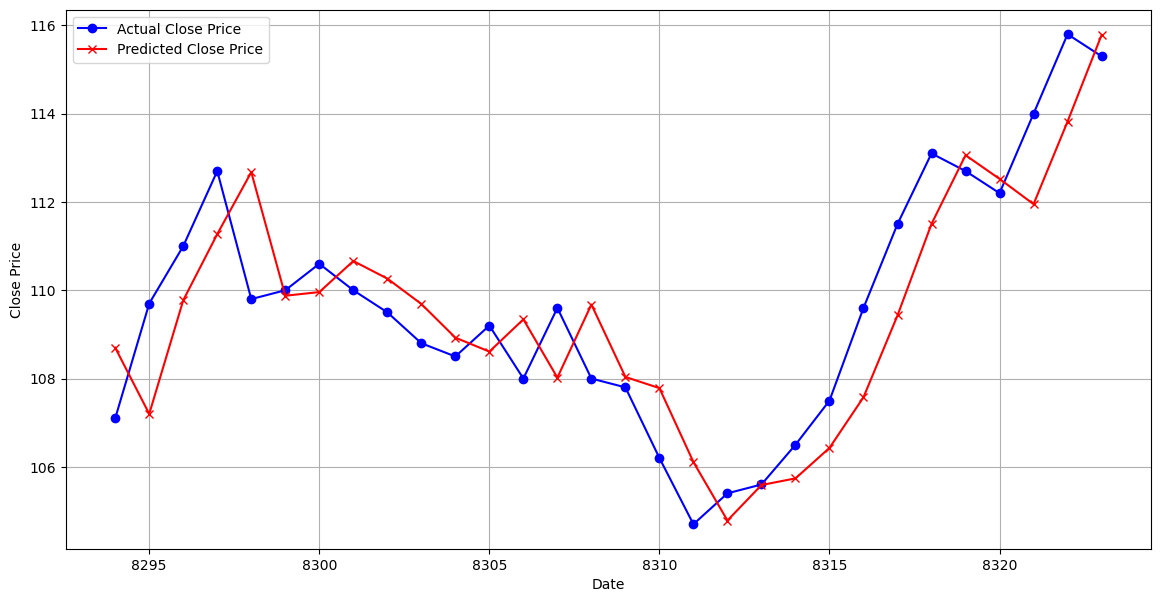

Lasso Regression RMSE: 2.2348519960457875, MAE: 1.775995513859946


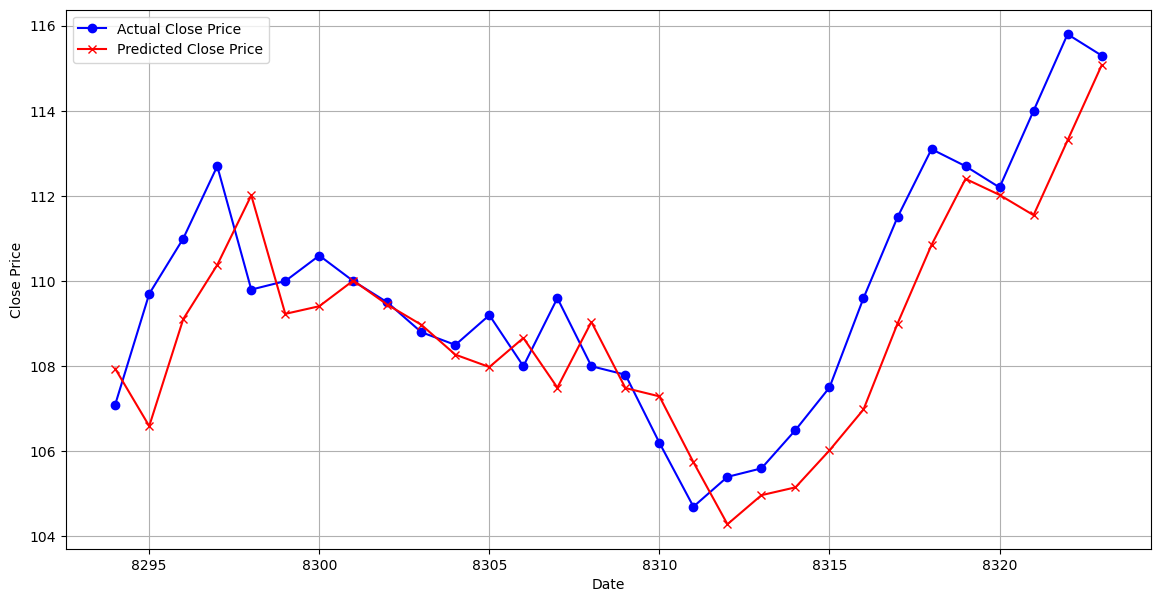

Elastic Net RMSE: 7.658887668723386, MAE: 7.167415340365742


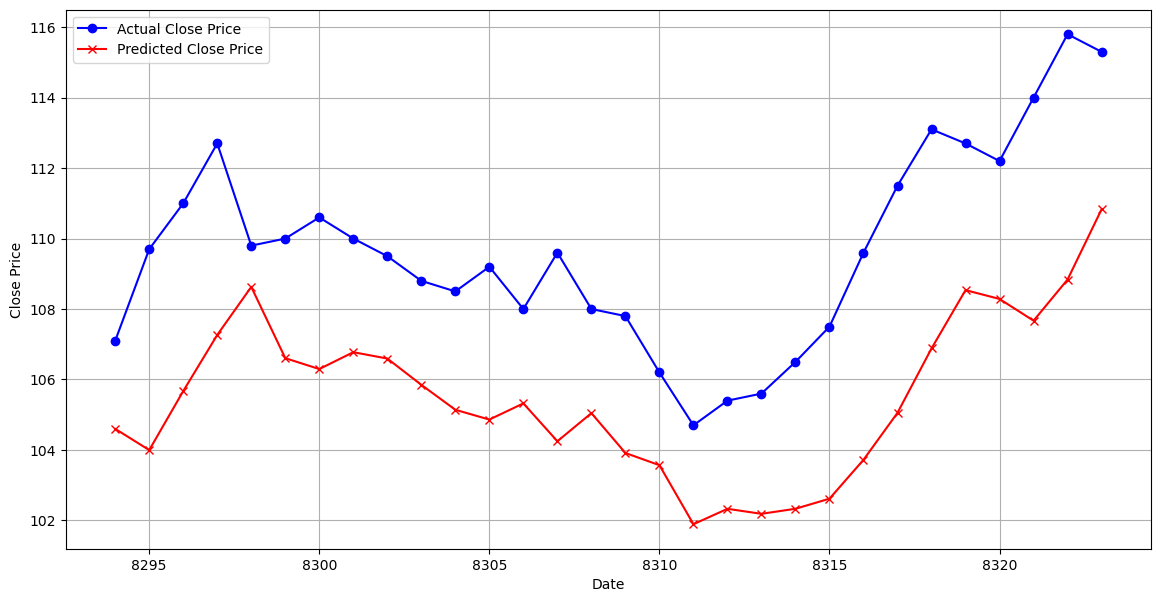

Support Vector Regression RMSE: 12.208762876536113, MAE: 9.659976636524418


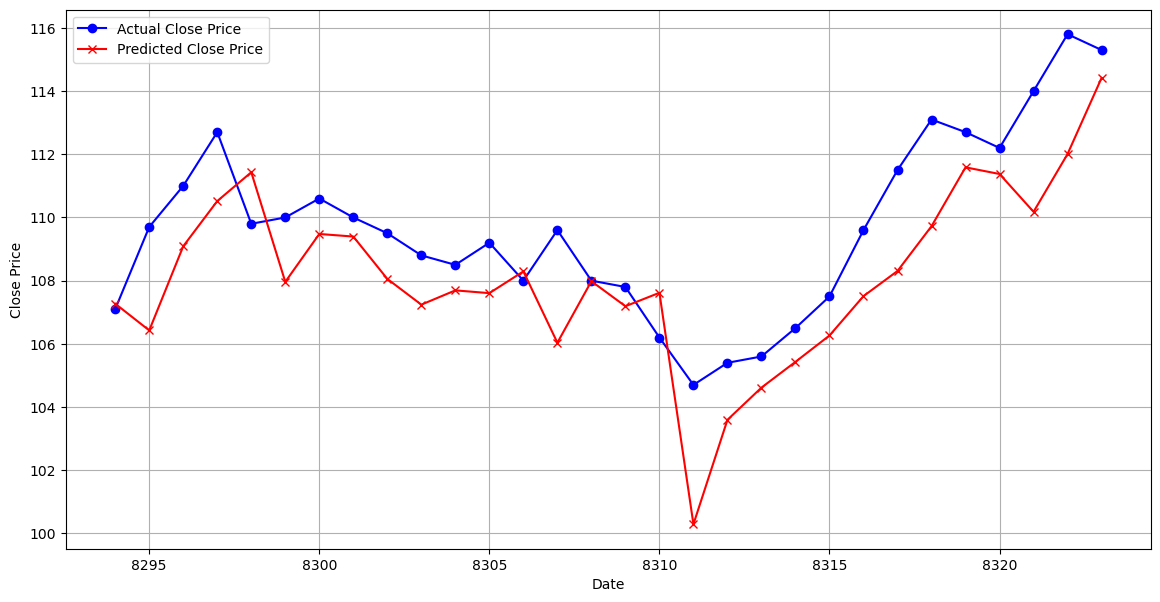

Gradient Boosting RMSE: 1.9900352855215713, MAE: 1.530086020368265


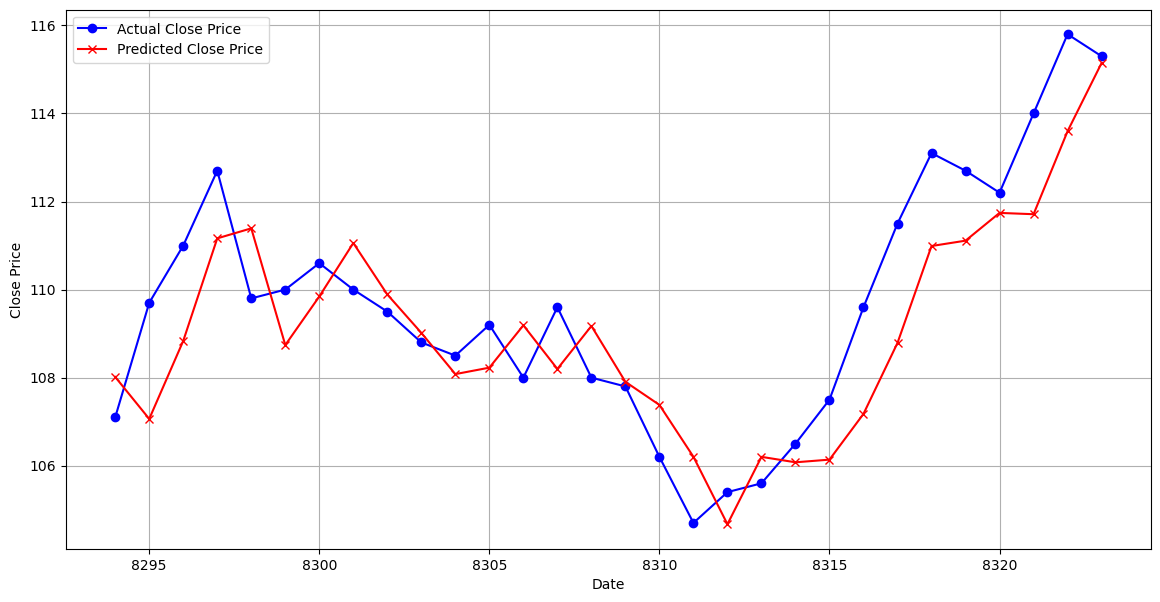

AdaBoost RMSE: 2.903793004652257, MAE: 2.2425573776276866


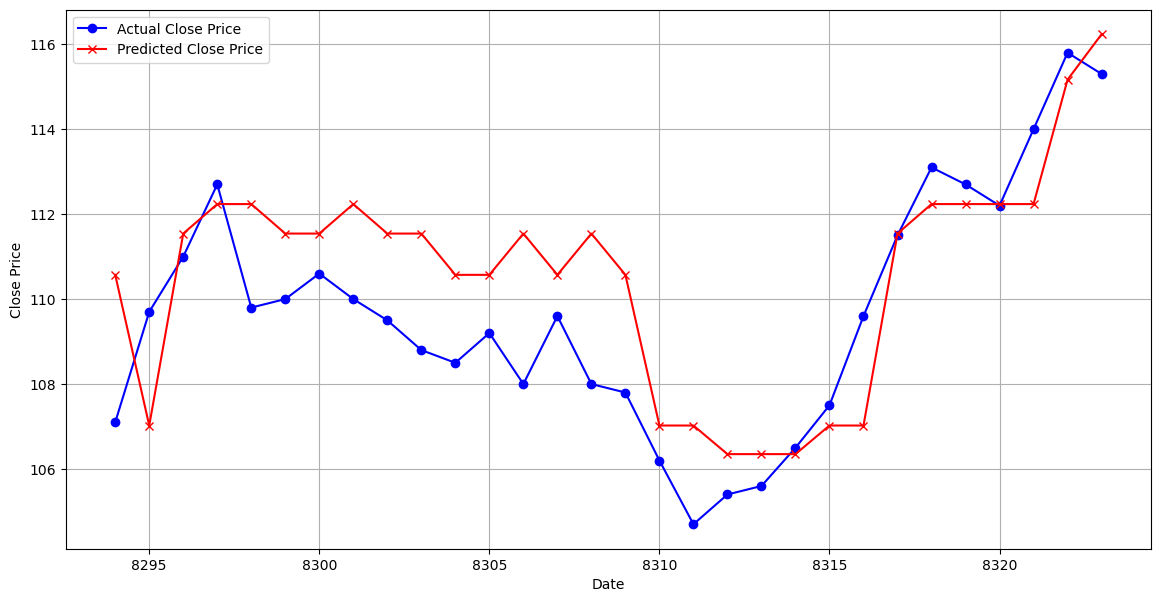

XGBoost RMSE: 3.033495606383525, MAE: 2.379551954280283


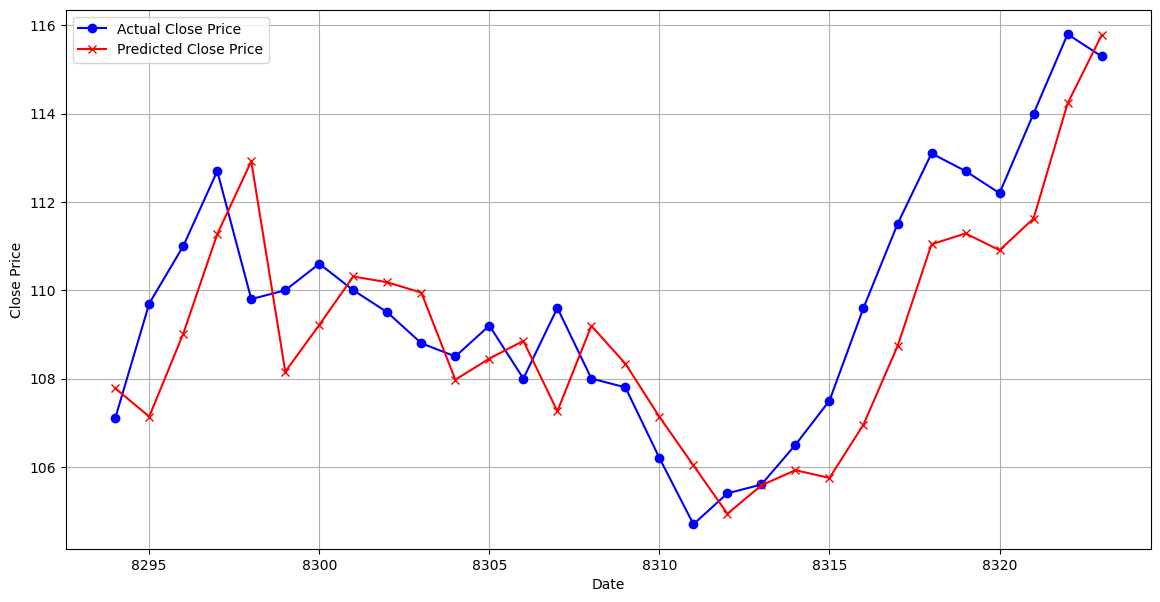


Sorted Metrics Results:
Ridge Regression: RMSE: 1.6549498541702314, MAE: 1.2444109834163553
Linear Regression: RMSE: 1.6736755306852225, MAE: 1.260710154530813
Gradient Boosting: RMSE: 1.9900352855215713, MAE: 1.530086020368265
Random Forest: RMSE: 2.059992618246289, MAE: 1.6018905359179048
Lasso Regression: RMSE: 2.2348519960457875, MAE: 1.775995513859946
AdaBoost: RMSE: 2.903793004652257, MAE: 2.2425573776276866
XGBoost: RMSE: 3.033495606383525, MAE: 2.379551954280283
Elastic Net: RMSE: 7.658887668723386, MAE: 7.167415340365742
Support Vector Regression: RMSE: 12.208762876536113, MAE: 9.659976636524418


In [19]:
models = {
    "Linear Regression": LinearRegression(),
    "Random Forest": RandomForestRegressor(n_estimators=100, random_state=42),
    "Ridge Regression": Ridge(),
    "Lasso Regression": Lasso(),
    "Elastic Net": ElasticNet(),
    "Support Vector Regression": SVR(),
    "Gradient Boosting": GradientBoostingRegressor(),
    "AdaBoost": AdaBoostRegressor(),
    "XGBoost": xgb.XGBRegressor(objective='reg:squarederror', random_state=42)
}

metrics_results = {}

for model_name, model in models.items():
    model.fit(X_train_scaled, y_train)
    predictions = model.predict(X_test_scaled)
    rmse = np.sqrt(mean_squared_error(y_test, predictions))
    mae = mean_absolute_error(y_test, predictions)
    metrics_results[model_name] = (rmse, mae)
    print(f'{model_name} RMSE: {rmse}, MAE: {mae}')
    plt.figure(figsize=(14, 7))
    plt.plot(y_test.index[:30], y_test[:30], label='Actual Close Price', color='blue', marker='o')
    plt.plot(y_test.index[:30], predictions[:30], label='Predicted Close Price', color='red', marker='x')
    plt.xlabel('Date')
    plt.ylabel('Close Price')
    plt.legend()
    plt.grid()
    plt.show()

sorted_metrics = sorted(metrics_results.items(), key=lambda x: x[1][0]) 
print("\nSorted Metrics Results:")
for name, (rmse, mae) in sorted_metrics:
    print(f'{name}: RMSE: {rmse}, MAE: {mae}')


### Remodelling the Problem - Classification Approach
As evident from the graph, the reason behind better performance of Linear Models in terms of RMSE and MAE is due to the fact that they are essentially replicating the previous close value. 

Hence the feature selection process had to be modified. We will now convert the problem into that of Classification (Price goes up OR down) and use mutual information to select the top-K features.

In [22]:
data['Target'] = np.where(data['Next_Day_Close'] > data['Close'], 1, 0)

split_date = '2020-12-31'  

train = data[data['Date'] < split_date]
test = data[data['Date'] >= split_date]

X_train = train.drop(columns=['Next_Day_Close', 'Date', 'Target'])
y_train = train['Target']

X_test = test.drop(columns=['Next_Day_Close', 'Date', 'Target'])
y_test = test['Target']

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

minmax_scaler = MinMaxScaler()
X_train_normalized = minmax_scaler.fit_transform(X_train_scaled)
X_test_normalized = minmax_scaler.transform(X_test_scaled)

In [23]:
from sklearn.feature_selection import mutual_info_classif

mi_scores = mutual_info_classif(X_train_normalized, y_train, discrete_features='auto')
mi_scores_df = pd.DataFrame({'Feature': X_train.columns, 'Mutual Information Score': mi_scores})
mi_scores_df = mi_scores_df.sort_values(by='Mutual Information Score', ascending=False)
print(mi_scores_df)

                 Feature  Mutual Information Score
0                  Close                  0.015121
27      Close_Open_Ratio                  0.011319
23     Open_Close_Spread                  0.010145
12                EMA_30                  0.010085
13          Volatility_5                  0.009697
16       Price_Change_30                  0.009418
28         Price_Range_5                  0.009172
15        Price_Change_5                  0.007926
2                   High                  0.006648
3                    Low                  0.006627
6                  Lag_1                  0.005795
7                  Lag_5                  0.005187
17                   RSI                  0.004773
20                  VWAP                  0.004711
21          Price_Change                  0.004589
31  Rolling_Mean_Returns                  0.003889
10                 MA_30                  0.003373
1                   Open                  0.003248
19                 Month       

In [27]:
non_zero_mi_scores_df = mi_scores_df[mi_scores_df['Mutual Information Score'] > 0]
selected_features = list(non_zero_mi_scores_df.Feature)

In [34]:
data[selected_features+['Target', 'Date', 'Next_Day_Close']].to_csv("feature_selected.csv")